# Proyek Klasifikasi Gambar:puneet6060/intel-image-classification

* Nama: ikrima Rai Saiddah
* Email: ikrimarai13@gmail.com
* ID Dicoding: ikrimars

## Import Semua Packages/Library yang Digunakan

In [2]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [3]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [22]:
!pip install --upgrade tensorflow
!pip install tensorflowjs
!pip install tensorflow

In [5]:
# Libraries untuk pembangunan model
import keras
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
import tensorflowjs as tfjs
# from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras import Model, layers, optimizers, regularizers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.applications.densenet import DenseNet121
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
# Mencetak versiyang sedang digunakan
print(f"{'Tensorflow Version':25}: {tf.__version__}")
print(f"{'TensorflowJS Version':25}: {tfjs.__version__}")
print(f"{'Matplotlib Version':25}: {matplotlib.__version__}")
print(f"{'Scikit-Learn Version':25}: {sklearn.__version__}")
print(f"{'Numpy Version':25}: {np.__version__}")
print(f"{'Pandas Version':25}: {pd.__version__}")

Tensorflow Version       : 2.18.0
TensorflowJS Version     : 4.22.0
Matplotlib Version       : 3.10.0
Scikit-Learn Version     : 1.6.1
Numpy Version            : 1.26.4
Pandas Version           : 2.2.2


## Data Preparation

### Data Loading

**Mengambil data dari kagle**

In [7]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ikrimaraisaiddah","key":"7f86c0ba4fd37af66734deb8298d3d18"}'}

In [11]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain

### Data Preprocessing

In [12]:
# Direktori awal untuk train dan test
train_dir = "seg_test/seg_test"
test_dir = "seg_train/seg_train"

# Direktori baru untuk dataset gabungan
dir = "imageClassification/dataset"

In [13]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(dir, exist_ok=True)

In [14]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(dir, category), dirs_exist_ok=True)

In [15]:
# format gambar yang diizinkan
formatted= ['.png', '.jpg', '.jpeg']

# list untuk label dan path
labels = []
path = []
# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for dirname, _, filenames in os.walk(dir):
    for filename in filenames:
        # format gambar pada file
        if os.path.splitext(filename)[-1].lower() in formatted:
            labels.append(os.path.split(dirname)[-1])
            path.append(os.path.join(dirname, filename))

# membuat dataframe
df = pd.DataFrame(columns=['path','labels'])
df['path']=path
df['labels']=labels
df.head()

,path,labels
0,imageClassification/dataset/buildings/4332.jpg,buildings
1,imageClassification/dataset/buildings/8312.jpg,buildings
2,imageClassification/dataset/buildings/7258.jpg,buildings
3,imageClassification/dataset/buildings/14710.jpg,buildings
4,imageClassification/dataset/buildings/16324.jpg,buildings


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17034 entries, 0 to 17033
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    17034 non-null  object
 1   labels  17034 non-null  object
dtypes: object(2)
memory usage: 266.3+ KB


In [17]:
#melihatkan informasi isi data
df['labels'].value_counts()

,count
labels,
mountain,3037
glacier,2957
street,2883
sea,2784
forest,2745
buildings,2628


In [18]:
#melihatkan data label
df['labels'].unique()

array(['buildings', 'mountain', 'glacier', 'street', 'sea', 'forest'],
      dtype=object)

Dataset intel image clasification terdapat 17024 dataset dgn type object/gambar.
Dataset ini memiliki 6 label diantaranya: 'buildings', 'mountain', 'glacier', 'street', 'sea', 'forest'. Dengan informasi jumlah data sebagai berikut:
* mountain	3037
* glacier	2957
* street	2883
* sea	2784
* forest	2745
* buildings	2628


#### Mengambil sampel gambar

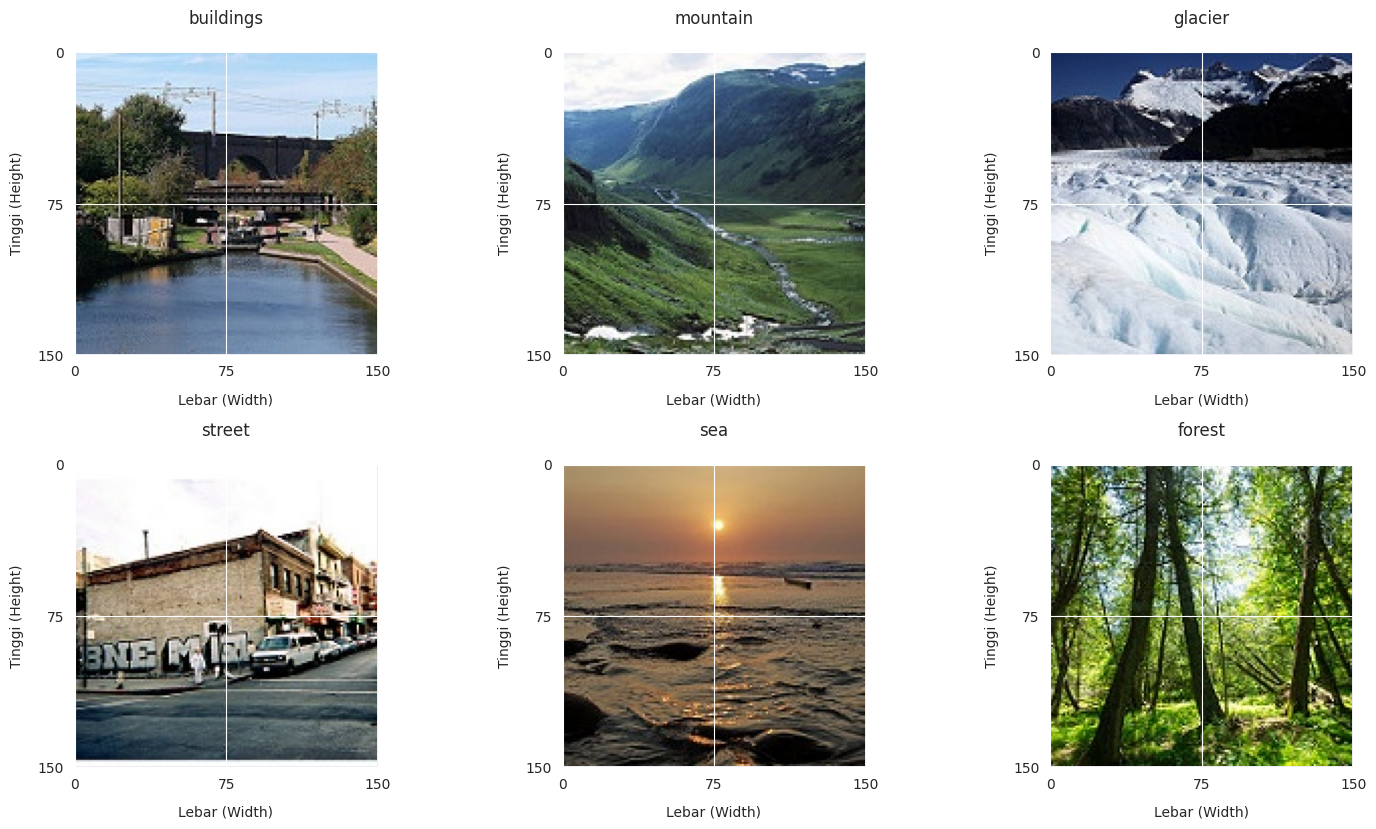

In [23]:
# Ambil daftar kategori unik
kategori_unik = df['labels'].unique()

# Atur ukuran plot
plt.figure(figsize=(15, 12))

# Loop untuk menampilkan satu gambar dari setiap kategori unik
for indeks, kategori in enumerate(kategori_unik):
    plt.subplot(3, 3, indeks + 1)  # Buat subplot (3 baris, 3 kolom)

    # Ambil path gambar pertama dari kategori saat ini
    path_gambar = df[df['labels'] == kategori].iloc[0, 0]

    # Baca dan tampilkan gambar
    gambar = plt.imread(path_gambar)
    plt.imshow(gambar)
    plt.title(kategori)  # Tambahkan judul dengan nama kategori
    plt.title(kategori, pad= 20)

    # Atur skala sumbu x dan y berdasarkan ukuran gambar
    tinggi, lebar = gambar.shape[:2]
    plt.xticks([0, lebar // 2, lebar], [0, lebar // 2, lebar])
    plt.yticks([0, tinggi // 2, tinggi], [0, tinggi // 2, tinggi])

    plt.xlabel('Lebar (Width)', labelpad=10)
    plt.ylabel('Tinggi (Height)', labelpad=10)
    plt.axis('on')  # Tampilkan sumbu koordinat

# Tata letak agar tidak saling tumpang tindih
plt.tight_layout()

# Tampilkan hasilnya
plt.show()

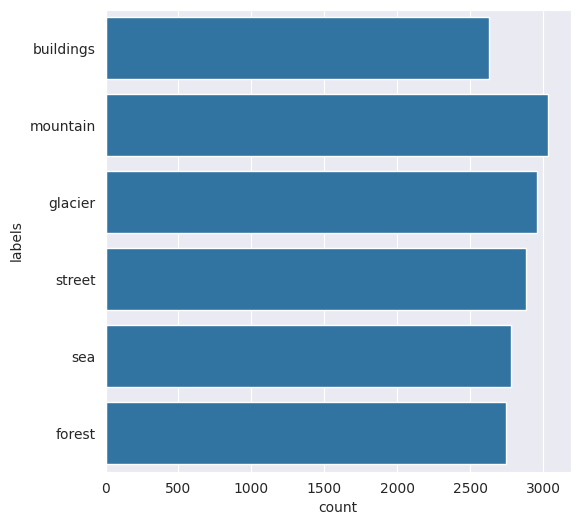

In [24]:
import seaborn as sns
distribution_train = pd.DataFrame({"path":path, 'file_name':dirname, "labels":labels})


# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

Berdasarkan hasil grafik distribusi data terdapat jumlah data yang tertinggi yaitu mountain dan yang terendah yaitu buildings. Namun, secara keseluruhan tidak ada imbalance data sekitar 2500-3000 data.

#### Split Dataset

In [25]:
# Contoh dataframe (df) harus berisi kolom ['image_path', 'label']
# df = pd.read_csv("path_to_csv")  # Jika datamu berasal dari CSV

# Membagi dataset menjadi training (80%) dan testing (20%)
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     shuffle=True,
                                     random_state=42)

# Cek jumlah data setelah split
print("Jumlah data training:", train_df.shape[0])
print("Jumlah data testing :", test_df.shape[0])

# Tambahkan kolom 'set' untuk menandai apakah data itu Training atau Testing
train_df['set'] = 'Train'
test_df['set'] = 'Test'

# Gabungkan kembali untuk analisis distribusi data
df_all = pd.concat([train_df, test_df], ignore_index=True)

# Tampilkan jumlah data per kategori untuk setiap set
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Tampilkan 5 sampel acak dari dataset gabungan
print(df_all.sample(5))

# # Path dataset asli & dataset hasil pembagian
datasource_path = "imageClassification/dataset/"  # Dataset asli
dataset_path = "datasetFinal/"  # Dataset setelah pembagian train-test

Jumlah data training: 13627
Jumlah data testing : 3407

set    labels   
Test   buildings     515
       forest        548
       glacier       589
       mountain      612
       sea           552
       street        591
Train  buildings    2113
       forest       2197
       glacier      2368
       mountain     2425
       sea          2232
       street       2292
dtype: int64 


                                                 path    labels    set
2291       imageClassification/dataset/forest/521.jpg    forest  Train
2521    imageClassification/dataset/glacier/10289.jpg   glacier  Train
7101   imageClassification/dataset/mountain/18894.jpg  mountain  Train
11932   imageClassification/dataset/glacier/13056.jpg   glacier  Train
13196       imageClassification/dataset/sea/18790.jpg       sea  Train


In [26]:
# Check shape of df
print(train_df.shape)
print(test_df.shape)

(13627, 3)
(3407, 3)


In [27]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)


0it [00:00, ?it/s]

In [28]:
# Definisikan direktori training dan test
TRAIN_DIR = "datasetFinal/Train/"
TEST_DIR = "datasetFinal/Test/"

train_buildings = os.path.join(TRAIN_DIR + '/buildings')
train_forest = os.path.join(TRAIN_DIR + '/forest')
train_glacier = os.path.join(TRAIN_DIR + '/glacier')
train_mountain = os.path.join(TRAIN_DIR + '/mountain')
train_sea = os.path.join(TRAIN_DIR + '/sea')
train_street = os.path.join(TRAIN_DIR + '/street')
test_buildings = os.path.join(TEST_DIR + '/buildings')
test_forest = os.path.join(TEST_DIR + '/forest')
test_glacier = os.path.join(TEST_DIR + '/glacier')
test_mountain = os.path.join(TEST_DIR + '/mountain')
test_sea = os.path.join(TEST_DIR + '/sea')
test_street = os.path.join(TEST_DIR + '/street')

print("Total number of buildings images in training set: ",len(os.listdir(train_buildings)))
print("Total number of forest images in training set: ",len(os.listdir(train_forest)))
print("Total number of glcier images in training set: ",len(os.listdir(train_glacier)))
print("Total number of mountain images in training set: ",len(os.listdir(train_mountain)))
print("Total number of sea images in training set: ",len(os.listdir(train_sea)))
print("Total number of street images in training set: ",len(os.listdir(train_street)))
print("Total number of buildings images in test set: ",len(os.listdir(test_buildings)))
print("Total number of forest images in test set: ",len(os.listdir(test_forest)))
print("Total number of glcier images in test set: ",len(os.listdir(test_glacier)))
print("Total number of mountain images in test set: ",len(os.listdir(test_mountain)))
print("Total number of sea images in test set: ",len(os.listdir(test_sea)))
print("Total number of street images in test set: ",len(os.listdir(test_street)))

Total number of buildings images in training set:  2113
Total number of forest images in training set:  2197
Total number of glcier images in training set:  2368
Total number of mountain images in training set:  2425
Total number of sea images in training set:  2232
Total number of street images in training set:  2292
Total number of buildings images in test set:  515
Total number of forest images in test set:  548
Total number of glcier images in test set:  589
Total number of mountain images in test set:  612
Total number of sea images in test set:  552
Total number of street images in test set:  591


Dataset intel image clasification, setelah dilakukan split data set sebesar 20% data test dan 80% data trai menghasilkan Jumlah data training: 13627 dan
Jumlah data testing : 3407. Dimana memiliki informasi detail data sebagai berikut:
> Data training:
* buildings images in training set:  2113
* forest images in training set:  2197
* glcier images in training set:  2368
* mountain images in training set:  2425
* sea images in training set:  2232
* street images in training set:  2292

> Data testing:
* buildings images in test set:  515
* forest images in test set:  548
* glcier images in test set:  589
* mountain images in test set:  612
* number of sea images in test set:  552
* street images in test set:  591


## Modelling

In [29]:
# preprocessing data
# Definisikan fungsi callback
def resize_image(img):
    img = cv2.resize(img, (150, 150))
    return img

# Data Augmentation (Meningkatkan Variasi Data, akurasi, generalisasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    validation_split=0.2,
    preprocessing_function=resize_image
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(TRAIN_DIR,
                                                              target_size=(150, 150),
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              subset='validation',
                                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=(150, 150),
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 10904 images belonging to 6 classes.
Found 2723 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.


Setelah itu dilakukan preprocessing data dimana

* train(pelatihan) memiliki  total 10.904 gambar dalam dataset yang terbagi ke dalam 6 kelas. Dalam tahap ini digunakan Data Augmentation (Meningkatkan Variasi Data, akurasi, generalisasi) dan juga dilakukan fungsi callback untuk menyamakan ukuran data gambar.

* validation (validasi) sebanyak
2.723 gambar, juga dalam 6 kelas.

* test (pengujian),sebanyak 3.407 gambar dalam 6 kelas.

### Pembangunan Model Parameter Tunning

In [30]:
# Pembangunan Model Parameter Tunning
# Load Pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze layer terakhir

# Unfreeze hanya beberapa layer terakhir agar tidak overfit
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Model Architecture
model = models.Sequential([
    base_model,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])
# Display the model summary
model.summary()

<ipython-input-30-c940dd8fcd8d>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 64)            │         737,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 5, 5, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 2, 2, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,138,182 (11.97 MB)

 Trainable params: 2,085,126 (7.95 MB)

 Non-trainable params: 1,053,056 (4.02 MB)

In [31]:
# Compile Model
optimizer = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 114s 273ms/step - accuracy: 0.6236 - loss: 1.4660 - val_accuracy: 0.8010 - val_loss: 1.0174 - learning_rate: 5.0000e-04
Epoch 2/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 114s 222ms/step - accuracy: 0.8210 - loss: 0.8571 - val_accuracy: 0.8748 - val_loss: 0.6969 - learning_rate: 5.0000e-04
Epoch 3/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 76s 222ms/step - accuracy: 0.8392 - loss: 0.7833 - val_accuracy: 0.8953 - val_loss: 0.6072 - learning_rate: 5.0000e-04
Epoch 4/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 76s 224ms/step - accuracy: 0.8622 - loss: 0.7112 - val_accuracy: 0.8663 - val_loss: 0.6577 - learning_rate: 5.0000e-04
Epoch 5/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 224ms/step - accuracy: 0.8658 - loss: 0.6525 - val_accuracy: 0.8887 - val_loss: 0.5756 - learning_rate: 5.0000e-04
Epoch 6/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 76s 224ms/step - accuracy: 0.8726 - loss: 0.6114 - val_accuracy: 0.8781 - val_loss: 0.5690 - learning_rate: 5.0000e-04
Epoch 7/25
341/341 ━━━━━━━━━━━━━━━━━━━━ 81s 

In [32]:
results = model.evaluate(validation_generator, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.32826
Test Accuracy: 92.47%


In [35]:
results = model.evaluate(test_generator, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.30868
Test Accuracy: 92.22%


**Hasilnya,**

setelah beberapa percobaan di dapatkan model mencapai nilai:
* akurasi Train sebesar 92.47% dan loss 0.32826
* akurasi Test sebesar 92.22% dan loss 0.30868

Digunakan model dengan menggunakan transfer learning MobileNetV2 dikarenakan data yang digunakan memiliki banyak data sehingga diperlukan model yang sudah dilatih agar hasil lebih baik dibanding pelatihan secara manual.

MobileNet V2 yang digunakan dilakukan fine-tuning untuk melatih layers model di dalamnya agar tidak terjadi overfitting dan mempertahankan akurasi yang baik.

**Saran**

* melakukan perbandingan dengan optimizers lainnya.
* melakukan percobaan berbagai augmentasi yang cocok untuk dataset.
* melakukan percobaan Model Architecture dan transfer learning lain.

### Evaluasi dan visualisasi

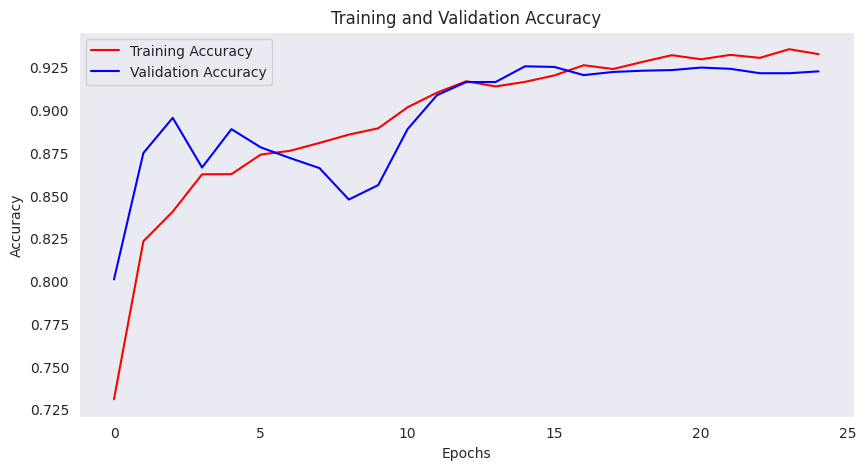

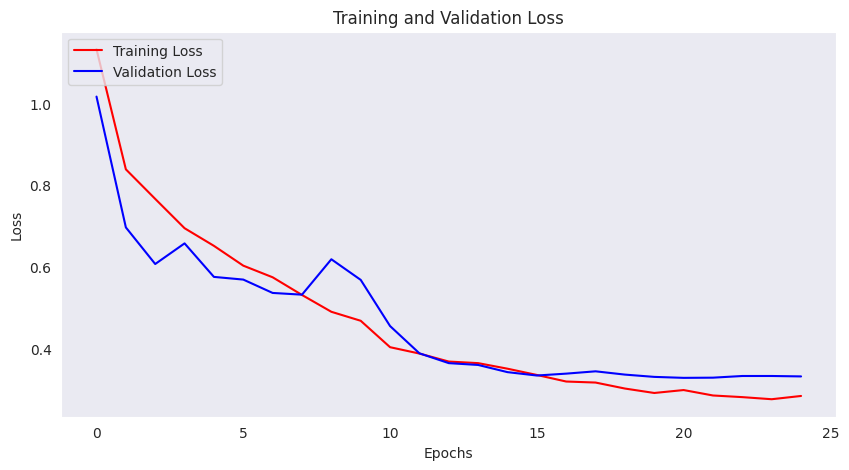

In [36]:
# grafik tanpa drop out 0.2
import matplotlib.pyplot as plt

# Mengambil data akurasi dan loss dari history training
acc_2 = history.history['accuracy']
val_acc_2 = history.history['val_accuracy']
loss_2 = history.history['loss']
val_loss_2 = history.history['val_loss']

epochs_2 = range(len(acc_2))

# Plot Akurasi
plt.figure(figsize=(10, 5))
plt.plot(epochs_2, acc_2, 'r', label='Training Accuracy')
plt.plot(epochs_2, val_acc_2, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_2, loss_2, 'r', label='Training Loss')
plt.plot(epochs_2, val_loss_2, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid()
plt.show()

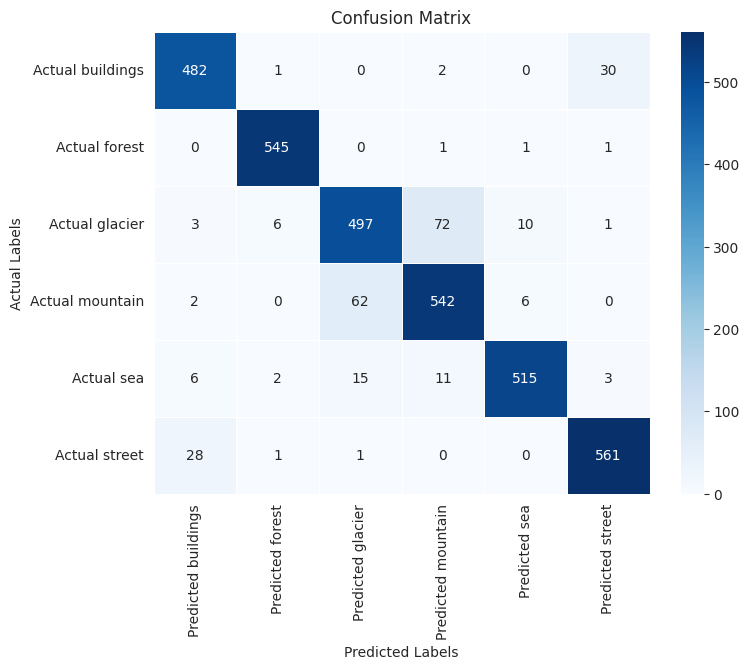


Classification Report:

              precision    recall  f1-score   support

   buildings     0.9251    0.9359    0.9305       515
      forest     0.9820    0.9945    0.9882       548
     glacier     0.8643    0.8438    0.8540       589
    mountain     0.8631    0.8856    0.8742       612
         sea     0.9680    0.9330    0.9502       552
      street     0.9413    0.9492    0.9452       591

    accuracy                         0.9222      3407
   macro avg     0.9240    0.9237    0.9237      3407
weighted avg     0.9224    0.9222    0.9222      3407



In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Reset test generator sebelum prediksi
test_generator.reset()

# Melakukan prediksi menggunakan model
predict = model.predict(test_generator, verbose=0)

# Mengambil kelas dengan probabilitas tertinggi
preds_labels = np.argmax(predict, axis=1)

# Definisi label kelas
class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Membuat Confusion Matrix
cm = confusion_matrix(test_generator.classes, preds_labels)

# Konversi ke DataFrame agar lebih mudah dibaca
cm_df = pd.DataFrame(cm, index=[f"Actual {cls}" for cls in class_labels],
                     columns=[f"Predicted {cls}" for cls in class_labels])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true=test_generator.classes,
                            y_pred=preds_labels,
                            target_names=class_labels, digits=4))


Model memiliki akurasi test sebesar 0.9222 (92.22%) dari total 3.407 gambar dengan benar.

Performa tidak merata antar kelas, pada "street" dan "Glacier" memiliki skor lebih rendah, mungkin karena kesamaan visual dengan kelas lain seperti street dan Mountain untuk kelas yang lebih sulit.

In [38]:
model.save("classification_modelTFL.h5")

## Konversi Model

### Convert TFServing

In [44]:
# Simpan model dalam format SavedModel
tf.saved_model.save(model, 'saved_model_dir')

### Convert TFJS

In [40]:
import tensorflowjs as tfjs

# os.makedirs(BaseDir+'tfjs_model', exist_ok=True)
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


### Convert TFLite

In [45]:
# Convert the model to TF-Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF-Lite model to a specific folder
os.makedirs('tf_lite', exist_ok=True)
# folder_path = 'tf_lite'
# file_path = f'{folder_path}/model.tflite'
file_path = f'tf_lite/model.tflite'
with open(file_path, 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp46a9p9yb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  131927028521808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131925381152592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131925369012880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131925381150864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131925381152208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131925381151056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131925369012688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131925369014224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131925369014416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131925369015184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1319253690

In [46]:
def recreate_labels():
    # labels = [folder for folder in os.listdir(dir) if not folder.startswith('.')]
    labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    with open('tf_lite/labels.txt', 'w') as file:
        for label in labels:
            file.write(label)
            file.write('\n')

recreate_labels()

## Inference

class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

### Model.h5

In [47]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load model
modelan = load_model("classification_modelTFL.h5")

# Baca gambar baru
# img_path = "path/to/new/image.jpg"
img_path = "seg_test/seg_test/buildings/20057.jpg" #buildings

img = cv2.imread(img_path)
img = cv2.resize(img, (150, 150))
img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
img = img / 255.0  # Normalisasi

# Prediksi
pred = modelan.predict(img)
print("Prediksi kelas:", np.argmax(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediksi kelas: 0


In [48]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load model
modelan = load_model("classification_modelTFL.h5")

# Baca gambar baru
# img_path = "path/to/new/image.jpg"
img_path = "seg_test/seg_test/forest/20056.jpg" #forest

img = cv2.imread(img_path)
img = cv2.resize(img, (150, 150))
img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
img = img / 255.0  # Normalisasi

# Prediksi
pred = modelan.predict(img)
print("Prediksi kelas:", np.argmax(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediksi kelas: 1


In [49]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load model
modelan = load_model("classification_modelTFL.h5")

# Baca gambar baru
# img_path = "path/to/new/image.jpg"
img_path = "seg_test/seg_test/glacier/20059.jpg" #glacier

img = cv2.imread(img_path)
img = cv2.resize(img, (150, 150))
img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
img = img / 255.0  # Normalisasi

# Prediksi
pred = modelan.predict(img)
print("Prediksi kelas:", np.argmax(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediksi kelas: 2


In [50]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load model
modelan = load_model("classification_modelTFL.h5")

# Baca gambar baru
# img_path = "path/to/new/image.jpg"
img_path = "seg_test/seg_test/mountain/20058.jpg" #mountain

img = cv2.imread(img_path)
img = cv2.resize(img, (150, 150))
img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
img = img / 255.0  # Normalisasi

# Prediksi
pred = modelan.predict(img)
print("Prediksi kelas:", np.argmax(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediksi kelas: 3


In [51]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load model
modelan = load_model("classification_modelTFL.h5")

# Baca gambar baru
# img_path = "path/to/new/image.jpg"
img_path = "seg_test/seg_test/sea/20072.jpg" #sea

img = cv2.imread(img_path)
img = cv2.resize(img, (150, 150))
img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
img = img / 255.0  # Normalisasi

# Prediksi
pred = modelan.predict(img)
print("Prediksi kelas:", np.argmax(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediksi kelas: 4


In [52]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load model
modelan = load_model("classification_modelTFL.h5")

# Baca gambar baru
# img_path = "path/to/new/image.jpg"
img_path = "seg_test/seg_test/street/20066.jpg" #street

img = cv2.imread(img_path)
img = cv2.resize(img, (150, 150))
img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
img = img / 255.0  # Normalisasi

# Prediksi
pred = modelan.predict(img)
print("Prediksi kelas:", np.argmax(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediksi kelas: 5


### model.TFlite

In [53]:
interpreter = tf.lite.Interpreter(model_path='tf_lite/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load labels
with open('tf_lite/labels.txt', 'r') as f:
    labels = [line.strip() for line in f.readlines()]

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [54]:
image_path = "seg_test/seg_test/buildings/20057.jpg" #buildings
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: buildings


In [55]:
image_path = "seg_test/seg_test/forest/20056.jpg" #forest
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: forest


In [56]:
image_path = "seg_test/seg_test/glacier/20059.jpg" #glacier
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: glacier


In [57]:
image_path = "seg_test/seg_test/mountain/20058.jpg" #mountain
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: mountain


In [58]:
image_path = "seg_test/seg_test/sea/20072.jpg" #sea
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: sea


In [59]:
image_path = "seg_test/seg_test/street/20066.jpg" #street
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: street


data di folder pred

In [60]:
image_path = "seg_pred/seg_pred/10013.jpg" #mountain
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: mountain


In [61]:
image_path = "seg_pred/seg_pred/10021.jpg" #forest
input_data = preprocess_image(image_path)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class_idx = np.argmax(output_data, axis=1)[0]
predicted_class = labels[predicted_class_idx]
print('Predicted Class:', predicted_class)

Predicted Class: forest


## Requirements

In [25]:
# Dengan pipreqs
# 1. Install pipreqs cukup 1x
# !pip install pipreqs

#2. Hubungkan Google Drive
from google.colab import drive
drive.mount('/content/drive')

# # 4. Gunakan pipreqs untuk membuat file requirements.txt
!pipreqs "/content/drive/My Drive/Latihan Python/project"
!pipreqs "/content/drive/My Drive/Latihan Python/project" --print
!pipreqs "/content/drive/My Drive/Latihan Python/project" --force

# # 5. Unduh file requirements.txt
# from google.colab import files
# files.download('/content/drive/My Drive/Latihan Python/project/requirements.txt')
# # files.download('requirements.txt')

# dengan pip freeze
# !pip freeze > requirements.txt
# from google.colab import files
# # # files.download('/content/drive/My Drive/Latihan Python/project/requirements.txt')
# langsung download
# files.download('requirements.txt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
INFO: Not scanning for jupyter notebooks.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requ